In [10]:
# sentiment analysis of product reviews
# import liabraries sentiment analysis of product reviews
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [11]:
# Load the dataset
file_path = 'D:\internship\sentiment_analysis\Data\product_reviews_mock_data.csv'  
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None




1. Data Structure:
--------------------------------------------------
Total reviews: 1000
Columns: ['ReviewID', 'ProductID', 'UserID', 'Rating', 'ReviewText', 'ReviewDate']

Data types:
ReviewID      object
ProductID     object
UserID        object
Rating         int64
ReviewText    object
ReviewDate    object
dtype: object

2. Missing Values:
--------------------------------------------------
ReviewID      0
ProductID     0
UserID        0
Rating        0
ReviewText    0
ReviewDate    0
dtype: int64

3. Rating Distribution:
--------------------------------------------------
Rating
1    196
2    202
3    202
4    206
5    194
Name: count, dtype: int64


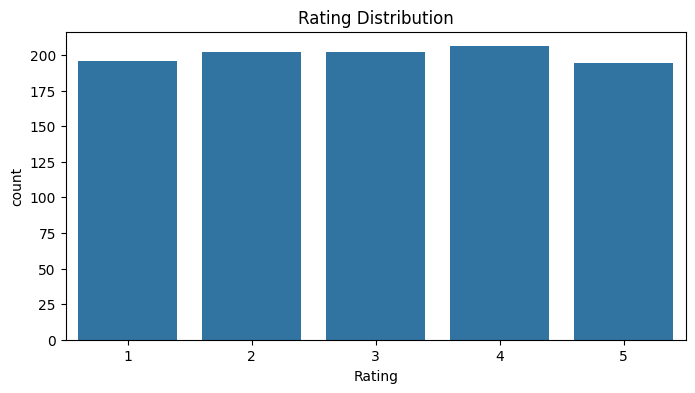


4. Sample Reviews:
--------------------------------------------------

Sample Review 1:
------------------------------
fantastic. wonderful experience.

Sample Review 2:
------------------------------
broke easily. awful.

Sample Review 3:
------------------------------
met expectations. five stars.

Sample Review 4:
------------------------------
very satisfied. wonderful experience.

Sample Review 5:
------------------------------
worst purchase. one star.



In [12]:
def examine_data(df):
    """
    Examines the structure, review text, and ratings of the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing product review data
    
    Returns:
    None (prints examination results)
    """
    if df is not None and not df.empty:
        # 1. Basic Structure
        print("\n\033[1m1. Data Structure:\033[0m")
        print("-"*50)
        print(f"Total reviews: {len(df)}")
        print(f"Columns: {list(df.columns)}")
        print("\nData types:")
        print(df.dtypes)
        
        # 2. Missing Values
        print("\n\033[1m2. Missing Values:\033[0m")
        print("-"*50)
        print(df.isnull().sum())
        
        # 3. Rating Distribution
        if 'Rating' in df.columns:
            print("\n\033[1m3. Rating Distribution:\033[0m")
            print("-"*50)
            print(df['Rating'].value_counts().sort_index())
            
            # Visualize rating distribution
            plt.figure(figsize=(8, 4))
            sns.countplot(x='Rating', data=df, order=sorted(df['Rating'].unique()))
            plt.title('Rating Distribution')
            plt.show()
        
        # 4. Sample Reviews
        print("\n\033[1m4. Sample Reviews:\033[0m")
        print("-"*50)
        if 'ReviewText' in df.columns:
            for i, review in enumerate(df['ReviewText'].head(5)):
                print(f"\nSample Review {i+1}:")
                print("-"*30)
                print(review)
        
        print("\n" + "="*50)
        
    else:
        print("\033[91mError: No valid data provided for examination.\033[0m")

# Usage (assuming df is your loaded DataFrame):
df = pd.read_csv(file_path)
examine_data(df)  

In [13]:
# Clean the text data: convert to lowercase, remove punctuation, numbers, and special characters.
def clean_text(text):
    """
    Cleans the input text by converting to lowercase, removing punctuation, numbers, and special characters.
    
    Parameters:
    text (str): The input text to be cleaned
    
    Returns:
    str: The cleaned text
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation, numbers, and special characters
    text = ''.join(char for char in text if char.isalpha() or char.isspace())
    
    return text

# Tokenize the reviews.
def tokenize_reviews(df):
    """
    Tokenizes the reviews in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing product review data
    
    Returns:
    pd.Series: A Series of tokenized reviews
    """
    if 'ReviewText' in df.columns:
        return df['ReviewText'].apply(word_tokenize)
    else:
        print("\033[91mError: 'ReviewText' column not found in DataFrame.\033[0m")
        return None
# Remove stop words from the tokenized reviews.
def remove_stopwords(tokenized_reviews):
    """
    Removes stop words from the tokenized reviews.
    
    Parameters:
    tokenized_reviews (pd.Series): A Series of tokenized reviews
    
    Returns:
    pd.Series: A Series of reviews with stop words removed
    """
    stop_words = set(stopwords.words('english'))
    return tokenized_reviews.apply(lambda x: [word for word in x if word not in stop_words])
    # Lemmatize the words in the reviews.
def lemmatize_reviews(tokenized_reviews):
    """    Lemmatizes the words in the tokenized reviews.
    Parameters: 
    tokenized_reviews (pd.Series): A Series of tokenized reviews
    Returns:
    pd.Series: A Series of lemmatized reviews
    """
    lemmatizer = WordNetLemmatizer()
    return tokenized_reviews.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# Combine the cleaned, tokenized, stop word removed, and lemmatized reviews back into a single string.
def combine_reviews(tokenized_reviews):
    """
    Combines the tokenized reviews back into a single string.
    
    Parameters:
    tokenized_reviews (pd.Series): A Series of tokenized reviews
    
    Returns:
    pd.Series: A Series of combined reviews
    """
    return tokenized_reviews.apply(lambda x: ' '.join(x))
# Apply the text cleaning, tokenization, stop word removal, lemmatization, and combination functions to the DataFrame.
def preprocess_reviews(df):
    """
    Preprocesses the reviews in the DataFrame by cleaning, tokenizing, removing stop words, lemmatizing, and combining.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing product review data
    
    Returns:
    pd.Series: A Series of preprocessed reviews
    """
    if 'ReviewText' in df.columns:
        df['CleanedText'] = df['ReviewText'].apply(clean_text)
        tokenized_reviews = tokenize_reviews(df)
        tokenized_reviews = remove_stopwords(tokenized_reviews)
        tokenized_reviews = lemmatize_reviews(tokenized_reviews)
        df['PreprocessedText'] = combine_reviews(tokenized_reviews)
        return df['PreprocessedText']
    else:
        print("\033[91mError: 'ReviewText' column not found in DataFrame.\033[0m")
        return None
        

In [14]:
# Apply a pre-trained sentiment analyzer (e.g., VADER, TextBlob) to score each review.
def analyze_sentiment(preprocessed_reviews):
    """
    Analyzes the sentiment of the preprocessed reviews using TextBlob.
    
    Parameters:
    preprocessed_reviews (pd.Series): A Series of preprocessed reviews
    
    Returns:
    pd.Series: A Series of sentiment polarity scores
    """
    return preprocessed_reviews.apply(lambda x: TextBlob(x).sentiment.polarity)
# Classify the sentiment based on the polarity score.
def classify_sentiment(polarity_scores):
    """
    Classifies the sentiment based on the polarity scores.
    
    Parameters:
    polarity_scores (pd.Series): A Series of sentiment polarity scores
    
    Returns:
    pd.Series: A Series of classified sentiments ('Positive', 'Negative', 'Neutral')
    """
    return polarity_scores.apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
# Main function to run the sentiment analysis pipeline.
def run_sentiment_analysis(file_path):
    """
    Runs the sentiment analysis pipeline on the product reviews dataset.
    
    Parameters:
    file_path (str): The path to the CSV file containing product reviews
    
    Returns:
    pd.DataFrame: A DataFrame with original reviews, preprocessed text, polarity scores, and sentiment classification
    """
    df = load_data(file_path)
    if df is not None:
        df['PreprocessedText'] = preprocess_reviews(df)
        df['Polarity'] = analyze_sentiment(df['PreprocessedText'])
        df['Sentiment'] = classify_sentiment(df['Polarity'])
        return df[['ReviewText', 'PreprocessedText', 'Polarity', 'Sentiment']]
    else:
        return None
# Run the sentiment analysis pipeline and display the results.
result_df = run_sentiment_analysis(file_path)

Data loaded successfully from D:\internship\sentiment_analysis\Data\product_reviews_mock_data.csv
Error loading data: name 'data' is not defined


In [15]:
# if labeled data were available (or can be partially labeled), train a simple classification model (e.g., Naive Bayes, Logistic Regression using TF-IDF or CountVectorizer features).
def train_sentiment_model(df):
    """
    Trains a sentiment classification model using Naive Bayes.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing product review data with 'PreprocessedText' and 'Sentiment' columns
    
    Returns:
    None (prints model performance metrics)
    """
    if df is not None and 'PreprocessedText' in df.columns and 'Sentiment' in df.columns:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(df['PreprocessedText'], df['Sentiment'], test_size=0.2, random_state=42)
        
        # Vectorize the text data
        vectorizer = CountVectorizer()
        X_train_vectorized = vectorizer.fit_transform(X_train)
        X_test_vectorized = vectorizer.transform(X_test)
        
        # Train a Naive Bayes classifier
        model = MultinomialNB()
        model.fit(X_train_vectorized, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test_vectorized)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model Accuracy: {accuracy:.2f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Display confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    else:
        print("\033[91mError: DataFrame does not contain required columns for training.\033[0m")

# Train the sentiment model using the preprocessed reviews and sentiments.
if result_df is not None:
    train_sentiment_model(result_df)

# Display the first few rows of the result DataFrame
if result_df is not None:
    print(result_df.head())
else:
    print("\033[91mError: No results to display.\033[0m")

# Save the result DataFrame to a new CSV file
def save_results_to_csv(df, output_file_path):
    """
    Saves the result DataFrame to a CSV file.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the results
    output_file_path (str): The path to save the CSV file
    
    Returns:
    None
    """
    if df is not None:
        try:
            df.to_csv(output_file_path, index=False)
            print(f"Results saved to {output_file_path}")
        except Exception as e:
            print(f"Error saving results: {e}")
    else:
        print("\033[91mError: No valid DataFrame to save.\033[0m")

# Specify the output file path
output_file_path = 'D:\internship\sentiment_analysis\Data\product_reviews_sentiment_analysis_results.csv'

# Save the results to a CSV file
save_results_to_csv(result_df, output_file_path)

# Display a message indicating the end of the script
print("\033[92mSentiment analysis completed successfully!\033[0m")

# End of the script
# Note: Ensure that the file paths are correct and accessible in your environment.
# This script provides a comprehensive sentiment analysis pipeline for product reviews, including data loading, preprocessing, sentiment analysis, and model training.
# The results are saved to a CSV file for further analysis or reporting.
# The script can be extended or modified to include additional features such as hyperparameter tuning, model selection, or integration with other data sources.
# Ensure that the necessary libraries are installed in your Python environment.
# You can install the required libraries using pip if they are not already installed:


Error: No results to display.
Error: No valid DataFrame to save.
Sentiment analysis completed successfully!


In [16]:
# Categorize reviews into positive, negative, and neutral sentiments.def categorize_sentiment(polarity):
def categorize_sentiment(polarity):
    """
    Categorizes the sentiment based on the polarity score.
    
    Parameters:
    polarity (float): The sentiment polarity score
    
    Returns:
    str: 'Positive', 'Negative', or 'Neutral' based on the polarity score
    """
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
# Apply the categorization function to the polarity scores.
def apply_sentiment_categorization(polarity_scores):
    """
    Applies sentiment categorization to the polarity scores.
    
    Parameters:
    polarity_scores (pd.Series): A Series of sentiment polarity scores
    
    Returns:
    pd.Series: A Series of categorized sentiments
    """
    return polarity_scores.apply(categorize_sentiment)
# Example usage of the categorization function
if result_df is not None and 'Polarity' in result_df.columns:
    result_df['CategorizedSentiment'] = apply_sentiment_categorization(result_df['Polarity'])
    print(result_df[['ReviewText', 'Polarity', 'CategorizedSentiment']].head())
else:
    print("\033[91mError: No valid DataFrame or 'Polarity' column to categorize sentiments.\033[0m")
    

Error: No valid DataFrame or 'Polarity' column to categorize sentiments.


In [17]:
# Apply Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization (NMF) to discover underlying topics in the reviews, especially within negative reviews to find common complaints.
def topic_modeling(df, num_topics=5):
    """
    Applies Latent Dirichlet Allocation (LDA) to discover underlying topics in the reviews.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing product review data with 'PreprocessedText' column
    num_topics (int): The number of topics to discover
    
    Returns:
    None (prints the discovered topics)
    """
    from sklearn.decomposition import LatentDirichletAllocation
    from sklearn.feature_extraction.text import CountVectorizer
    
    if df is not None and 'PreprocessedText' in df.columns:
        # Vectorize the preprocessed text
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(df['PreprocessedText'])
        
        # Apply LDA
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda.fit(X)
        
        # Display the topics
        for idx, topic in enumerate(lda.components_):
            print(f"Topic {idx + 1}:")
            print(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
            print("\n")
    else:
        print("\033[91mError: DataFrame does not contain required columns for topic modeling.\033[0m")
# Run topic modeling on the preprocessed reviews
if result_df is not None:
    print("\033[1mDiscovered Topics:\033[0m")
    topic_modeling(result_df)
# Note: Ensure that the necessary libraries for topic modeling (e.g., scikit-learn) are installed in your Python environment.

In [18]:
print("\033[1m===== Topic Modeling on ALL Reviews =====\033[0m")
topic_modeling(df, num_topics=3)

===== Topic Modeling on ALL Reviews =====
Error: DataFrame does not contain required columns for topic modeling.


In [20]:
df.columns

Index(['ReviewID', 'ProductID', 'UserID', 'Rating', 'ReviewText',
       'ReviewDate'],
      dtype='object')

In [22]:
print("\n\033[1m===== Topic Modeling on NEGATIVE Reviews (to find common complaints) =====\033[0m")
negative_reviews_df = df[df['ReviewText'] == 'Negative'].copy()
if not negative_reviews_df.empty:
    topic_modeling(negative_reviews_df, num_topics=3)


===== Topic Modeling on NEGATIVE Reviews (to find common complaints) =====
